In [1]:
prm_seal_population = io.load('prm_seal_population')
prm_seal_population

2019-08-04 22:08:17,474 - kedro.io.data_catalog - INFO - Loading data from `prm_seal_population` (CSVLocalDataSet)...


,Years,Fermented Seal Population (Thousands)
0,-10.040080,22.233980
1,0.000000,3.507502
2,0.030060,3.523078
3,0.060120,3.922211
4,0.090180,3.630186
5,0.120240,3.917598
6,0.150301,3.930257
7,0.180361,3.675354
8,0.210421,3.732614
9,0.240481,3.915168


1. Fit the model using robust regression.  Compute the robust standard deviation of the residuals (RSDR, defined in Equation 1).

In [2]:
import numpy as np


def func(t, C, k, m):
    r"""Define logistic growth :math:`g(t)=\frac{C}{1+exp(-k(t-m))}`."""
    # pylint: disable=invalid-name
    return C / (1 + np.exp(-k * (t - m)))

In [3]:
xdata = prm_seal_population.Years * 10**3
ydata = prm_seal_population['Fermented Seal Population (Thousands)'] * 10**3

In [4]:
from scipy.optimize import curve_fit


popt, pcov = curve_fit(func, xdata, ydata)
popt

/anaconda3/envs/rout-example/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


array([2.43934553e+04, 4.13268133e-04, 4.46271470e+03])

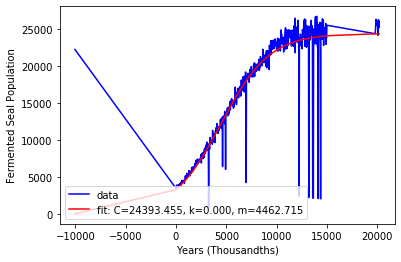

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit: C=%5.3f, k=%5.3f, m=%5.3f' % tuple(popt))
plt.xlabel('Years (Thousandths)')
plt.ylabel('Fermented Seal Population')
plt.legend()
plt.show()

In [6]:
residuals = abs(ydata - func(xdata, *popt)) / func(xdata, *popt)  # Weighted
P68 = np.percentile(residuals, 68.27)

N = xdata.size
K = 3
RSDR = P68 * N / (N-K)

2. Decide on a value for Q.  We recommend setting Q to 1%.

In [7]:
Q = 0.01

3. Rank the absolute value of the residuals from low to high, so ResidualN corresponds to the point furthest from the curve.

In [8]:
import pandas as pd


residuals_ranked = pd.Series(residuals, index=prm_seal_population.index).sort_values()
residuals_ranked

248      0.000101
284      0.000105
500      0.000153
146      0.000166
100      0.000194
38       0.000423
106      0.000431
147      0.000627
481      0.000779
135      0.000881
405      0.000945
166      0.001200
159      0.001435
269      0.001638
287      0.001669
251      0.001823
304      0.001962
307      0.002406
453      0.002455
387      0.002460
210      0.002925
238      0.003220
342      0.003278
244      0.003332
312      0.003362
334      0.003494
65       0.003519
186      0.003552
316      0.003612
42       0.004062
          ...    
347      0.106032
72       0.106626
428      0.109733
103      0.111417
461      0.114251
425      0.114974
465      0.116448
122      0.117397
403      0.118266
6        0.118622
53       0.118710
21       0.122050
5        0.126950
32       0.130300
67       0.130952
394      0.135814
44       0.138195
37       0.142905
3        0.152616
155      0.488629
165      0.546715
233      0.761734
407      0.895219
109      0.900219
439      0

4. Loop from i = int(0.70*N) to N (we only test the 30% of the points furthest from the curve).

In [9]:
from scipy import stats


outlier = []
for i, (index, residual) in enumerate(residuals_ranked.iteritems()):
    if i < 0.70 * N:
        outlier.append(False)
        continue
    alpha = Q * (N - i) / N  # i is 0-indexed here, 1-indexed in the paper
    t = residual / RSDR
    
    # c. Compute the two-tailed P value from the t distribution with N-K degrees of freedom (N is number of data points; K is number of parameters fit by nonlinear regression).
    p = 2 * stats.t.sf(t, N - K)
    outlier.append(p < alpha)

pd.Series(outlier, residuals_ranked.index).sum()

11

In [10]:
joined = prm_seal_population.join(pd.Series(outlier, index=residuals_ranked.index, name='Outlier'))
joined[joined.Outlier]

,Years,Fermented Seal Population (Thousands),Outlier
0,-10.040080,22.233980,True
109,3.246493,0.917431,True
155,4.629259,6.451613,True
165,4.929860,6.060606,True
233,6.973948,4.291845,True
407,12.234469,2.457002,True
439,13.196393,2.277904,True
452,13.587174,2.212389,True
454,13.647295,2.202643,True
470,14.128257,2.127660,True


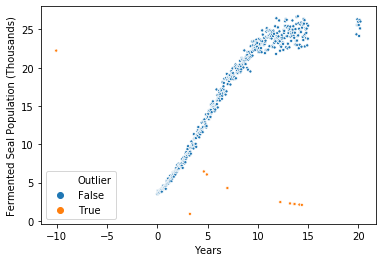

In [11]:
import seaborn as sns


sns.scatterplot('Years', 'Fermented Seal Population (Thousands)', hue='Outlier', data=joined, s=10)